In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
from torch.optim import Adam
from tqdm import tqdm
import torch
import dataset_utils_trans as data
import utils as utils
import numpy as  np
import random


In [2]:

#%% 
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(42)


In [3]:
# base_dir = "/home/18307110500/pj1-workplace/"
# data_dir = "/home/18307110500/data/"

base_dir = "/home/mlsnrs/data/data/lff/ai-lab/lab3/"
data_dir = base_dir + "../../data/"

prefix = "transformer_glove"

if not os.path.exists(f"model/{prefix}"):
    os.makedirs(f"model/{prefix}")

lr = 1e-3
decay = 1e-4

device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size= 64
num_workers = 4
num_epochs = 50

In [4]:
# Load dataset
# train_set_imdb = data.ImdbDatasetLoader(f"{data_dir}/aclImdb/train")
data_weight = 0.1
train_set_imdb = None
# 
train_set = data.DatasetLoader(f"{data_dir}/fudan_nlp/train.data")
dev_set = data.DatasetLoader(f"{data_dir}/fudan_nlp/valid.data")

# building vocabulary
vocab, idx_to_word = data.build_vocab([
    train_set, dev_set])

# word->idx
if train_set_imdb is not None:
    train_set_imdb.convert_word_to_idx(vocab)
train_set.convert_word_to_idx(vocab)
dev_set.convert_word_to_idx(vocab)

# samples: 8596
# samples: 1000


In [5]:
# pretrain words vector
import torchtext.vocab as Vocab

glove_vocab = Vocab.GloVe(name='6B', dim=100, cache=os.path.join(data_dir+"/fudan_nlp/", "glove"))
print(len(glove_vocab.stoi)) # 400000
print(glove_vocab[0].shape)

vocab_weights = data.load_pretrained_embedding(vocab.keys(), glove_vocab)

400000
torch.Size([100])
There are 736 oov words.
['<pad>', '<unk>', '', 'eckstraordinarily', 'cletis', 'swordfights', 'completist', '�the', 'slappingly', 'clichand', 'gantzes', 'surfacey', 'reeboir', 'recurre', 'clich�s', 'g�nero', 'actuaci�n', 'perdona', 'gui�n', 'guessable', 'aceitou', 'continua��o', 'sa�do', 'pesquerdo', 'aqueles', 'decidiram', 'assistir', 'tamb�m', 'unimpressively', 'aborbing', 'histo', 'third�emotionally', 'coriat', 'miscasts', 'likableness', 'contando', 'premissa', 'mergulha', 'culminando', 'desfecho', 'certamente', 'mem�ria', 'enrapturing', 'clich�d', 'nonjudgmentally', 'bottomlessly', 'travil', 'clutchy', 'pistoled', 'vocsinta', 'necessidade', 't�rmino', 'proje��o', 'n�o', 'preocupe', 'ningu�m', 'lhe', 'enviarpenas', 'simbolizando', 'covardia', 'birot', 'wifty', 'wisegirls', 'nrelentingly', 'jirhubac', 'rintars', 'gabbiest', 'nonethnic', 'crummles', 'almod�var', 'logra', 'entra�able', 'compasi�n', 'comprensi�n', 'inolvidable', 'shimmeringly', 'schneidermeister

In [6]:
from transformer_enc import Transformer_cls
model = Transformer_cls(
    pretrain_weights=vocab_weights,
    pad_size=100,
    num_head=5,
    num_encoder=2,
    embed_dim=100, 
    hidden=512,
    num_class=2, dropout=0.8)
print(model)

Transformer_cls(
  (input_embedding): Embedding(17540, 100)
  (postion_embedding): Positional_Encoding(
    (dropout): Dropout(p=0.01, inplace=False)
  )
  (encoder): Encoder(
    (attention): Multi_Head_Attention(
      (fc_Q): Linear(in_features=100, out_features=100, bias=True)
      (fc_K): Linear(in_features=100, out_features=100, bias=True)
      (fc_V): Linear(in_features=100, out_features=100, bias=True)
      (attention): Scaled_Dot_Product_Attention()
      (fc): Linear(in_features=100, out_features=100, bias=True)
      (dropout): Dropout(p=0.8, inplace=False)
      (layer_norm): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
    )
    (feed_forward): Position_wise_Feed_Forward(
      (fc1): Linear(in_features=100, out_features=512, bias=True)
      (fc2): Linear(in_features=512, out_features=100, bias=True)
      (dropout): Dropout(p=0.8, inplace=False)
      (layer_norm): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
    )
  )
  (encoders): ModuleList(
    (

In [7]:
model.to(device)
optimizer = Adam(model.parameters(), lr=lr, weight_decay=decay) 
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# train
loss_tr_his , acc_tr_his = [],[]
loss_dev_his , acc_dev_his = [],[]

the_best = {'eval_acc': 100,
            'model_path':''}

In [8]:
import utils as utils
loss_aux_his , acc_aux_his = [],[]

In [9]:
# train_set = dev_set
for epo in range(num_epochs): 
    # train once in imdb if not none
    # train once in fudan dataset
    if train_set_imdb is not None:
        (batch_avg_loss, batch_avg_acc),(
            l_,a_) = utils.train_batch_cross_domain(
            model, train_set, train_set_imdb, batch_size, num_workers, device,
            optimizer, weighted=data_weight)
            
        loss_aux_his.append(l_)
        acc_aux_his.append(a_)
        loss_tr_his.append(batch_avg_loss)
        acc_tr_his.append(batch_avg_acc)

    else:
        batch_avg_loss, batch_avg_acc = utils.train_batch(
            model, train_set, batch_size, num_workers, device,
            optimizer)    
        loss_tr_his.append(batch_avg_loss)
        acc_tr_his.append(batch_avg_acc)


    # eval once
    eval_loss, eval_acc, _, __ = utils.eval(model, dev_set, batch_size, num_workers, device)
    loss_dev_his.append(eval_loss)
    acc_dev_his.append(eval_acc)

    print(f"epoch[{epo}]  tr_loss: {batch_avg_loss}   tr_acc: {batch_avg_acc}   eval_loss: {eval_loss}   eval_acc: {eval_acc}")

    # save
    if eval_acc >= max(acc_dev_his):
        the_best['model_path'] =  f"model/{prefix}_best.pth"
        the_best['eval_acc'] =  eval_acc
        
        torch.save(model, the_best['model_path'])
        
        print(f"ckp: save as { the_best['model_path'] }, acc {the_best['eval_acc']}")

100%|██████████| 135/135 [00:02<00:00, 48.48it/s]


epoch[0]  tr_loss: 0.96990764274526   tr_acc: 0.5088413215449046   eval_loss: 1.0898583809534708   eval_acc: 0.49
ckp: save as model/transformer_glove_best.pth, acc 0.49


100%|██████████| 135/135 [00:02<00:00, 62.90it/s]


epoch[1]  tr_loss: 0.8587938929671672   tr_acc: 0.4965100046533271   eval_loss: 0.7339594086011251   eval_acc: 0.514
ckp: save as model/transformer_glove_best.pth, acc 0.514


100%|██████████| 135/135 [00:02<00:00, 63.19it/s]


epoch[2]  tr_loss: 0.7806899285138543   tr_acc: 0.5575849232201023   eval_loss: 1.2351144154866536   eval_acc: 0.61
ckp: save as model/transformer_glove_best.pth, acc 0.61


100%|██████████| 135/135 [00:02<00:00, 64.75it/s]


epoch[3]  tr_loss: 0.6944952858472938   tr_acc: 0.640181479758027   eval_loss: 0.923708458741506   eval_acc: 0.699
ckp: save as model/transformer_glove_best.pth, acc 0.699


100%|██████████| 135/135 [00:02<00:00, 63.27it/s]


epoch[4]  tr_loss: 0.6470981593897094   tr_acc: 0.6855514192647744   eval_loss: 1.0032046914100647   eval_acc: 0.689


100%|██████████| 135/135 [00:02<00:00, 63.38it/s]


epoch[5]  tr_loss: 0.6372978193546409   tr_acc: 0.6840390879478827   eval_loss: 0.8545212308565776   eval_acc: 0.725
ckp: save as model/transformer_glove_best.pth, acc 0.725


100%|██████████| 135/135 [00:02<00:00, 60.48it/s]


epoch[6]  tr_loss: 0.6040551039709974   tr_acc: 0.7067240577012563   eval_loss: 0.7234614710013072   eval_acc: 0.732
ckp: save as model/transformer_glove_best.pth, acc 0.732


100%|██████████| 135/135 [00:02<00:00, 64.02it/s]


epoch[7]  tr_loss: 0.5992651977645818   tr_acc: 0.7061423918101443   eval_loss: 0.7942051986853281   eval_acc: 0.729


100%|██████████| 135/135 [00:02<00:00, 61.34it/s]


epoch[8]  tr_loss: 0.5780049117643442   tr_acc: 0.7220800372266171   eval_loss: 0.8188329656918844   eval_acc: 0.724


100%|██████████| 135/135 [00:02<00:00, 64.21it/s]


epoch[9]  tr_loss: 0.5753088589034864   tr_acc: 0.7210330386226151   eval_loss: 0.6674766679604848   eval_acc: 0.741
ckp: save as model/transformer_glove_best.pth, acc 0.741


100%|██████████| 135/135 [00:02<00:00, 65.07it/s]


epoch[10]  tr_loss: 0.5453172661920092   tr_acc: 0.7387156817124244   eval_loss: 1.0099162042140961   eval_acc: 0.742
ckp: save as model/transformer_glove_best.pth, acc 0.742


100%|██████████| 135/135 [00:02<00:00, 59.77it/s]


epoch[11]  tr_loss: 0.5419280766995985   tr_acc: 0.7361563517915309   eval_loss: 0.6650221765041351   eval_acc: 0.749
ckp: save as model/transformer_glove_best.pth, acc 0.749


100%|██████████| 135/135 [00:02<00:00, 64.19it/s]


epoch[12]  tr_loss: 0.5240306425005642   tr_acc: 0.754071661237785   eval_loss: 0.8402293821175894   eval_acc: 0.75
ckp: save as model/transformer_glove_best.pth, acc 0.75


100%|██████████| 135/135 [00:02<00:00, 60.44it/s]


epoch[13]  tr_loss: 0.5275267344802174   tr_acc: 0.7382503489995347   eval_loss: 0.7059413055578868   eval_acc: 0.758
ckp: save as model/transformer_glove_best.pth, acc 0.758


100%|██████████| 135/135 [00:02<00:00, 61.83it/s]


epoch[14]  tr_loss: 0.5026653887175802   tr_acc: 0.7594229874360168   eval_loss: 0.8141897102197011   eval_acc: 0.757


100%|██████████| 135/135 [00:02<00:00, 62.50it/s]


epoch[15]  tr_loss: 0.5031922917757461   tr_acc: 0.7616333178222429   eval_loss: 1.224004828929901   eval_acc: 0.709


100%|██████████| 135/135 [00:02<00:00, 63.48it/s]


epoch[16]  tr_loss: 0.48798066777969473   tr_acc: 0.7645416472778036   eval_loss: 0.8030315021673838   eval_acc: 0.756


100%|██████████| 135/135 [00:02<00:00, 64.33it/s]


epoch[17]  tr_loss: 0.47852374924652613   tr_acc: 0.7676826430898093   eval_loss: 0.7209992468357086   eval_acc: 0.753


100%|██████████| 135/135 [00:02<00:00, 65.86it/s]


epoch[18]  tr_loss: 0.46037384556300603   tr_acc: 0.7812936249418334   eval_loss: 0.8741949915885925   eval_acc: 0.746


100%|██████████| 135/135 [00:02<00:00, 59.45it/s]


epoch[19]  tr_loss: 0.4663177370580275   tr_acc: 0.7781526291298279   eval_loss: 0.8731891731421153   eval_acc: 0.749


100%|██████████| 135/135 [00:02<00:00, 65.27it/s]


epoch[20]  tr_loss: 0.45253208724420463   tr_acc: 0.7862959516053979   eval_loss: 1.0200103680292765   eval_acc: 0.744


100%|██████████| 135/135 [00:02<00:00, 61.45it/s]


epoch[21]  tr_loss: 0.4382107423535034   tr_acc: 0.7944392740809679   eval_loss: 0.8034491936365763   eval_acc: 0.746


100%|██████████| 135/135 [00:02<00:00, 63.91it/s]


epoch[22]  tr_loss: 0.4269398731082233   tr_acc: 0.8002559329920893   eval_loss: 0.8264021356900533   eval_acc: 0.751


100%|██████████| 135/135 [00:02<00:00, 62.69it/s]


epoch[23]  tr_loss: 0.4225310518670438   tr_acc: 0.800953932061424   eval_loss: 0.8770356913407643   eval_acc: 0.747


100%|██████████| 135/135 [00:02<00:00, 64.23it/s]


epoch[24]  tr_loss: 0.4122218848831618   tr_acc: 0.8116565844578874   eval_loss: 0.7976934313774109   eval_acc: 0.76
ckp: save as model/transformer_glove_best.pth, acc 0.76


100%|██████████| 135/135 [00:02<00:00, 62.94it/s]


epoch[25]  tr_loss: 0.41321401742856895   tr_acc: 0.8078175895765473   eval_loss: 1.0127253313859303   eval_acc: 0.755


100%|██████████| 135/135 [00:02<00:00, 63.30it/s]


epoch[26]  tr_loss: 0.39817779222086297   tr_acc: 0.8161935784085621   eval_loss: 0.974535220861435   eval_acc: 0.75


100%|██████████| 135/135 [00:02<00:00, 64.88it/s]


epoch[27]  tr_loss: 0.382216458333962   tr_acc: 0.8277105630525826   eval_loss: 0.8367109159628551   eval_acc: 0.754


100%|██████████| 135/135 [00:02<00:00, 61.50it/s]


epoch[28]  tr_loss: 0.37797435373067856   tr_acc: 0.8282922289436947   eval_loss: 0.9590697348117828   eval_acc: 0.744


100%|██████████| 135/135 [00:02<00:00, 65.61it/s]


epoch[29]  tr_loss: 0.35672438166924375   tr_acc: 0.8378315495579339   eval_loss: 0.8836664358774821   eval_acc: 0.76
ckp: save as model/transformer_glove_best.pth, acc 0.76


100%|██████████| 135/135 [00:02<00:00, 61.79it/s]


epoch[30]  tr_loss: 0.36472731561803107   tr_acc: 0.8324802233597022   eval_loss: 0.8818227450052897   eval_acc: 0.749


100%|██████████| 135/135 [00:02<00:00, 62.48it/s]


epoch[31]  tr_loss: 0.35372500399600215   tr_acc: 0.8356212191717077   eval_loss: 1.0063076078891755   eval_acc: 0.757


100%|██████████| 135/135 [00:02<00:00, 64.61it/s]


epoch[32]  tr_loss: 0.34720205915952795   tr_acc: 0.8439972080037227   eval_loss: 1.044683446486791   eval_acc: 0.744


100%|██████████| 135/135 [00:02<00:00, 64.99it/s]


epoch[33]  tr_loss: 0.34628958255052567   tr_acc: 0.8458585388552815   eval_loss: 1.0179104367891947   eval_acc: 0.748


100%|██████████| 135/135 [00:02<00:00, 65.57it/s]


epoch[34]  tr_loss: 0.3298280153479149   tr_acc: 0.8494648673801768   eval_loss: 1.0028174976507822   eval_acc: 0.755


100%|██████████| 135/135 [00:02<00:00, 63.98it/s]


epoch[35]  tr_loss: 0.3207223424826985   tr_acc: 0.8520241973010703   eval_loss: 0.9058557987213135   eval_acc: 0.754


100%|██████████| 135/135 [00:02<00:00, 56.28it/s]


epoch[36]  tr_loss: 0.3160064679695599   tr_acc: 0.8616798510935318   eval_loss: 1.0224418838818867   eval_acc: 0.741


100%|██████████| 135/135 [00:02<00:00, 64.19it/s]


epoch[37]  tr_loss: 0.3128322295066136   tr_acc: 0.8633085155886459   eval_loss: 0.9695145984490713   eval_acc: 0.75


100%|██████████| 135/135 [00:02<00:00, 61.72it/s]


epoch[38]  tr_loss: 0.30305031453495596   tr_acc: 0.8677291763610981   eval_loss: 0.9924452662467956   eval_acc: 0.73


100%|██████████| 135/135 [00:02<00:00, 62.65it/s]


epoch[39]  tr_loss: 0.293454728130974   tr_acc: 0.8737785016286646   eval_loss: 1.2042481243610381   eval_acc: 0.739


100%|██████████| 135/135 [00:02<00:00, 66.74it/s]


epoch[40]  tr_loss: 0.29256151783377377   tr_acc: 0.8754071661237784   eval_loss: 1.1115175783634186   eval_acc: 0.737


100%|██████████| 135/135 [00:02<00:00, 66.68it/s]


epoch[41]  tr_loss: 0.28612566183307275   tr_acc: 0.8727315030246626   eval_loss: 1.1307882924874624   eval_acc: 0.737


100%|██████████| 135/135 [00:02<00:00, 65.46it/s]


epoch[42]  tr_loss: 0.27355067020476753   tr_acc: 0.8811074918566775   eval_loss: 1.1183185398578643   eval_acc: 0.73


100%|██████████| 135/135 [00:02<00:00, 65.14it/s]


epoch[43]  tr_loss: 0.26446340972585464   tr_acc: 0.8836668217775709   eval_loss: 1.1693351805210113   eval_acc: 0.733


100%|██████████| 135/135 [00:02<00:00, 64.59it/s]


epoch[44]  tr_loss: 0.25121115409393807   tr_acc: 0.8920428106095859   eval_loss: 1.2394198517004649   eval_acc: 0.727


100%|██████████| 135/135 [00:02<00:00, 63.82it/s]


epoch[45]  tr_loss: 0.2483537803723741   tr_acc: 0.8929734760353653   eval_loss: 1.1674232264359792   eval_acc: 0.737


100%|██████████| 135/135 [00:02<00:00, 60.01it/s]


epoch[46]  tr_loss: 0.25360792508321023   tr_acc: 0.8889018147975802   eval_loss: 1.0606508612632752   eval_acc: 0.732


100%|██████████| 135/135 [00:02<00:00, 64.53it/s]


epoch[47]  tr_loss: 0.23446289789098412   tr_acc: 0.9025127966496045   eval_loss: 1.2641198098659516   eval_acc: 0.729


100%|██████████| 135/135 [00:02<00:00, 59.51it/s]


epoch[48]  tr_loss: 0.23127452150654437   tr_acc: 0.9011167985109353   eval_loss: 1.6533191740512847   eval_acc: 0.734


100%|██████████| 135/135 [00:02<00:00, 64.33it/s]


epoch[49]  tr_loss: 0.2364066589846095   tr_acc: 0.9019311307584923   eval_loss: 1.4640129824479422   eval_acc: 0.727


In [10]:
def test_and_write(_data_iter, type="test"):
    preds= []

    for step, _batch in tqdm(enumerate(_data_iter)):
        model.eval()
        x,y=_batch
        with torch.no_grad():
            loss, pred = model(x.to(device), y.to(device))
            pred = pred.detach().cpu().numpy().tolist()
            preds.extend(pred)

    print(f'# {type} pred:', preds)

    with open(f'model/{prefix}/{type}_{len(loss_tr_his)}_res.txt',encoding="utf-8", mode='w') as f:
        for pred in preds:
            f.write("positive" if pred==1 else 'negative')
            f.write('\n')


## load the best model
model = torch.load(the_best['model_path'])


## 写出test结果到txt
test_set = data.DatasetLoader(f"{data_dir}/fudan_nlp/test.data",test=True)

test_set.convert_word_to_idx(vocab)

test_data_iter=test_set.get_sequential_iter(batch_size, num_workers)
test_and_write(test_data_iter,type="test")

dev_data_iter= dev_set.get_sequential_iter(batch_size, num_workers)
test_and_write(dev_data_iter,type="valid")

# samples: 1066


17it [00:00, 115.36it/s]

# test pred: [0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,


16it [00:00, 104.12it/s]

# valid pred: [0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1

In [11]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def plot_(losses:dict, acces:dict, save=None):
    num_fig = 2
    plt.figure(num_fig, figsize=(8, 8))
    plt.grid(True)
    
    plt.subplot(num_fig, 1, 1)

    data_f = pd.DataFrame(losses)
    sns.scatterplot(data=data_f)


    plt.subplot(num_fig, 1, 2)
    data_f = pd.DataFrame(acces)
    sns.scatterplot(data=data_f)
    
    plt.savefig(save)

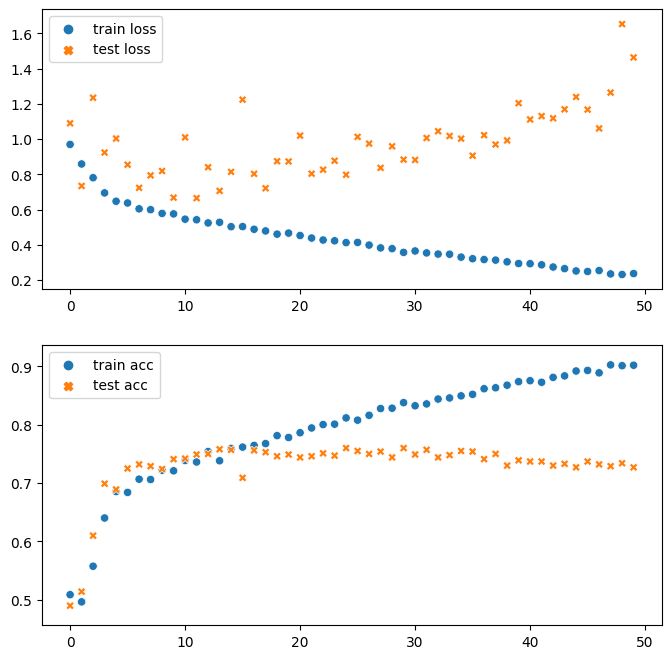

In [12]:
def plot():
    def get_cpu(tuples):
        new_his = []
        for t in tuples:
            new_his.append(t.cpu().item())
        return new_his

    ls = {"train loss":loss_tr_his,
          "test loss":loss_dev_his,
        #   "aux train loss": loss_aux_his
        }

    accs = {"train acc":acc_tr_his,
          "test acc":acc_dev_his,
        #   "aux train acc": acc_aux_his
        }
    plot_(ls, accs,  save =
          f"model/{prefix}/{len(acc_tr_his)}-{the_best['eval_acc']}.png")


plot()

In [13]:
print("best eval loss:", min(loss_dev_his))
print("best eval acc:", max(acc_dev_his))

print("best train loss:", min(loss_tr_his))
print("best train acc:", max(acc_tr_his))

best eval loss: 0.6650221765041351
best eval acc: 0.76
best train loss: 0.23127452150654437
best train acc: 0.9025127966496045
